In [1]:
import os
import subprocess
import time
import random
import pygad
import configparser
from geomdl import exchange, multi, BSpline, operations, utilities
from geomdl.operations import rotate
from geomdl.visualization import VisMPL as vis
import numpy as np
import open3d as o3d
import copy
import pandas as pd
import time
import csv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to calculate the length of the curve given control points (degree 3)
def calculate_curve_length(ctrlpts):
    curve = BSpline.Curve()
    curve.degree = 3
    curve.ctrlpts = ctrlpts
    curve.knotvector = utilities.generate_knot_vector(curve.degree, curve.ctrlpts_size)
    curve.delta = 0.01
    return operations.length_curve(curve)

In [3]:
# Function to calculate the width of the curve given control points (degree 2)
def calculate_curve_width(ctrlpts):
    curve = BSpline.Curve()
    curve.degree = 2
    curve.ctrlpts = ctrlpts
    curve.knotvector = utilities.generate_knot_vector(curve.degree, curve.ctrlpts_size)
    curve.delta = 0.01
    return operations.length_curve(curve)

In [4]:
def scale_length(points, multiplier, exclude_indices=[0,6,12], inplace=True):
    # Scale control points along the x-axis
    for idx, pt in enumerate(points):
        if idx not in exclude_indices:
            pt[0] *= multiplier
    return points

In [5]:
def scale_width(points, multiplier, exclude_indices=[1], inplace=True):
    # Scale control points along the y-axis
    for idx, pt in enumerate(points):
        if idx not in exclude_indices:
            pt[1] *= multiplier
    return points

In [6]:
def create_plant_obj(ga_instance, chromosome_idx, lengths, widths, theta, phi):
    # Load the surface data from a JSON file
    data = exchange.import_json("../3d_files/new_Mo17_manually_copy.json")
    surf_cont = multi.SurfaceContainer(data)

    for idx, surface_data in enumerate(surf_cont[1:]):
        # Step 1: calculate initial length and scaling factor
        initial_len = calculate_curve_length(surface_data.ctrlpts[6:12])
        scale_factor_len = lengths[idx] / initial_len

        # Step 2: Scale the control points for length
        scaled_len_ctrlpts = scale_length(surface_data.ctrlpts, scale_factor_len)

        # Step 3: Update the surface control points
        surface_data.ctrlpts = scaled_len_ctrlpts

        # Step 4: Extract control points sets in the v-direction after length scaling
        v_dir_sets = [surface_data.ctrlpts[i:i+6] for i in range(0, len(surface_data.ctrlpts), 6)]

        # Step 5: calculate initial width and scaling factor
        initial_width = calculate_curve_width([v_dir_set[2] for v_dir_set in v_dir_sets])
        width_factor = widths[idx] / initial_width

        # Step 6: Calculate and scale the widths
        for j in range(1, 5):
            curve_control_points = [v_dir_set[j] for v_dir_set in v_dir_sets]
            scaled_width_cntrlpts = scale_width(curve_control_points, width_factor)

            # Step 7: Update the v_dir_sets with the scaled width control points
            for k, v_dir_set in enumerate(v_dir_sets):
                v_dir_set[j] = scaled_width_cntrlpts[k]

        # Step 8: Rotate the surface
        z_angle = theta[idx]
        y_angle = phi[idx]
        rotate(surface_data, angle=z_angle, axis=2, inplace=True)
        rotate(surface_data, angle=y_angle, axis=1, inplace=True)

#     surf_cont.vis = vis.VisSurface(ctrlpts=False, trims=False)
#     surf_cont.render()
    # Export the updated surface to an OBJ file
    num_gen = ga_instance.generations_completed
    export_path = f"../GA_rotate10_120x24_initpop_200/meshes/chromosome_{num_gen}_{chromosome_idx}.obj"
    exchange.export_obj(surf_cont, export_path)
    return export_path

In [7]:
import open3d as o3d
import numpy as np
import copy
import csv
import random

def create_field(file_path, row_spacing, plant_spacing):
    mesh = o3d.io.read_triangle_mesh(file_path)
    
    # Scale the mesh to meters (assuming the current units are in centimeters)
    scale_factor = 0.01
    mesh.scale(scale_factor, center=mesh.get_center())
    
    # Translate the original mesh to the origin
    mesh.translate(-mesh.get_center())
    o3d.io.write_triangle_mesh(file_path, mesh)
    
    field = o3d.geometry.TriangleMesh()
    rotation_angles = []
    for i in range(-3, 3):  # Adjusted to -3 to 2 for a 6x6 field
        for j in range(-3, 3):  # Adjusted to -3 to 2 for a 6x6 field
            # Create a deep copy of the mesh and then translate it
            cloned_mesh = copy.deepcopy(mesh)
            
            # Apply a random rotation between -10 and 10 degrees around the Z-axis
            rotation_angle = random.uniform(-10, 10)
            rotation_radians = np.radians(rotation_angle)
            rotation_matrix = cloned_mesh.get_rotation_matrix_from_axis_angle([0, 0, rotation_radians])
            cloned_mesh.rotate(rotation_matrix, center=(0, 0, 0))

            translated_mesh = cloned_mesh.translate(np.array([i * plant_spacing, j * row_spacing, 0]), relative=True)
            field += translated_mesh
            
            rotation_angles.append(rotation_angle)

    # Translate the field by 0.5 * plant_spacing in the x direction and 0.5 * row_spacing in the y direction
    field.translate((-0.5 * plant_spacing, 0.5 * row_spacing, 0))

    # Crop a portion of the field
    cropped_field = field.crop(o3d.geometry.AxisAlignedBoundingBox(
        min_bound=(-2 * plant_spacing, -2 * row_spacing, -np.inf),
        max_bound=(2 * plant_spacing, 2 * row_spacing, np.inf)
    ))
    
    csv_file_path = "/work/mech-ai-scratch/nasla/PAR_model/GA_rotate10_120x24_initpop_200/rotation_info.csv"
    with open(csv_file_path, mode='a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([file_path] + rotation_angles)
        
    # Generate the output filepath by replacing ".obj" with "_field_cropped.obj"
    output_filepath = file_path.replace('.obj', '_field_cropped.obj')

    # Save the field mesh with the new name
    o3d.io.write_triangle_mesh(output_filepath, cropped_field)
    
#     # Print the center of the cropped field
#     center = cropped_field.get_center()
#     print(f"Center of the cropped field: {center}")

    return output_filepath

# Example usage
# file_path = "GA_rotate30/meshes/chromosome_97_64.obj"
# row_spacing = 0.00762
# plant_spacing = 0.001524
# output_filepath = create_field(file_path, row_spacing, plant_spacing)

# output_filepath

In [8]:
def update_config_file(config_file_path, field_path):
    config = configparser.ConfigParser()
    config.read(config_file_path)
    config.set('Paths', 'fieldfilepath', field_path)  # Update with field path
    with open(config_file_path, 'w') as configfile:
        config.write(configfile)

In [9]:
# Function to run the Helios simulation
def run_helios(config_file_path, device_id):
    try:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(device_id)
#         process = subprocess.Popen(
#             ["./par_parallel", config_file_path], stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, 
#             cwd="/work/mech-ai-scratch/nasla/helios_new/Helios/samples/par_parallel/build"
#         )
        process = subprocess.Popen(
            "module load mesa-glu && module load boost/1.86.0-gvbpdbb && ./par_parallel " + config_file_path,
            shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
            cwd="/work/mech-ai-scratch/nasla/helios_new/Helios/samples/par_parallel/build"
        )
        stdout, _ = process.communicate()

        if process.returncode == 0:
            return extract_PAR_from_output(stdout.decode())
        else:
            print("Helios execution failed with return code:", process.returncode)
            return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None

In [10]:
def extract_PAR_from_output(output):
    for line in output.splitlines():
        if "PAR_VALUE:" in line:
            return float(line.split(":")[-1].strip())
    return None

In [11]:
def fitness_func(ga_instance, chromosome, chromosome_idx):
    try:
        # Reshape the chromosome to extract lengths, widths, theta, and phi
        chromosome_sets = np.reshape(chromosome, (4, 10))
        lengths = chromosome_sets[0]
        widths = chromosome_sets[1]
        theta = chromosome_sets[2]
        phi = chromosome_sets[3]

        # Create plant object and get the path
        plant_path = create_plant_obj(ga_instance, chromosome_idx, lengths, widths, theta, phi)

        # Set row and plant spacing in meters
        row_spacing = 0.762
        plant_spacing = 0.1524

        # Create the field and get the field path
        field_path = create_field(plant_path, row_spacing, plant_spacing)

        # Determine GPU ID and corresponding config file path
        gpu_id = (chromosome_idx % 8) // 2
        config_file_id = chromosome_idx % 8
        config_file_path = f"/work/mech-ai-scratch/nasla/helios_new/Helios/samples/par_parallel/configs/helios_config_gpu{config_file_id}.ini"

        # Update the configuration file with the new paths
        update_config_file(config_file_path, os.path.abspath(field_path))

        # Run the Helios simulation and get the PAR value
        PAR = run_helios(config_file_path, gpu_id)
        print(f"Chromosome Index: {chromosome_idx}, PAR Value: {PAR}, GPU: {gpu_id}")

        # Return the PAR value as the fitness score
        if PAR is not None:
            if np.isnan(PAR):
                print(f"PAR is NaN for chromosome index {chromosome_idx}, returning 0.0")
                return 0.0
            else:
                return PAR
        else:
            print(f"Chromosome Index: {chromosome_idx}, PAR is None, returning 0.0")
            return 0.0
    except Exception as e:
        print(f"Error in fitness function for chromosome index {chromosome_idx}: {str(e)}")
        return 0.0

In [12]:
last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")

    # Ensure fitness array does not contain NaN values
    pop_fitness = np.nan_to_num(ga_instance.last_generation_fitness, nan=0.0)
    
    if pop_fitness.size > 0:
        best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution(pop_fitness=pop_fitness)
        print(f"Fitness    = {best_solution_fitness}")
        print(f"Change     = {best_solution_fitness - last_fitness}")
        last_fitness = best_solution_fitness
    else:
        print("Warning: Population fitness array is empty!")
        last_fitness = 0

In [13]:
gene_space = [
    {'low': 40, 'high': 110}, # For lengths
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 40, 'high': 110},
    {'low': 5, 'high': 14}, # For widths
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14},
    {'low': 5, 'high': 14}, 
    {'low': 0, 'high': 360}, # For theta
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': 0, 'high': 360},
    {'low': -45, 'high': 45}, # For phi
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45},
    {'low': -45, 'high': 45}
]

In [14]:
num_generations = 300

num_parents_mating = 100
# initial_pop = init_pop

sol_per_pop = 200
num_genes = 40
keep_elitism = 20

# init_range_low = 0.0
# init_range_high = 1.0

# parent_selection_type = "sss"
# keep_parents = 5

# crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [15]:
# def main():
# #     loaded_ga_instance = pygad.load(filename='/work/mech-ai-scratch/nasla/Augmentation_strategies/saved_models/color_geo_cut/ga_instance')
    
#     ga_instance = pygad.GA(sol_per_pop=sol_per_pop,
#                        num_genes=num_genes,
#                        gene_type=[float, 1],
#                        num_generations=num_generations,
#                        num_parents_mating=num_parents_mating,
#                        fitness_func=fitness_func,
# #                        parent_selection_type=parent_selection_type,
#                        keep_elitism = keep_elitism,  
#                        mutation_type=mutation_type,
#                       gene_space = gene_space,
#                        mutation_percent_genes=mutation_percent_genes,
#                        on_generation=on_generation,
#                        save_best_solutions=True,
#                        save_solutions=True)
                          
#     ga_instance.run()
#     pd.DataFrame(ga_instance.best_solutions).to_csv('/work/mech-ai-scratch/nasla/PAR_model/GA_test1/best_solutions.csv')
    
#     pd.DataFrame(ga_instance.solutions).to_csv('/work/mech-ai-scratch/nasla/PAR_model/GA_test1/solutions.csv')
#     ga_instance.plot_fitness(save_dir='/work/mech-ai-scratch/nasla/PAR_model/GA_test1/fitness.png')
    
   
#     solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
#     print("Solution", solution)
#     print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
#     ga_instance.save(filename='/work/mech-ai-scratch/nasla/PAR_model/GA_test1/ga_instance')
#     pd.DataFrame(ga_instance.best_solutions_fitness).to_csv('/work/mech-ai-scratch/nasla/PAR_model/GA_test1/best_solutions_fitness.csv')

In [16]:
def main():
    try:
        
#         loaded_ga_instance = pygad.load(filename='/work/mech-ai-scratch/nasla/PAR_model/GA_test1/ga_instance')
        ga_instance = pygad.GA(
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            gene_type=[float, 1],
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=fitness_func,
            keep_elitism=keep_elitism,  
            mutation_type=mutation_type,
            gene_space=gene_space,
            mutation_percent_genes=mutation_percent_genes,
            on_generation=on_generation,
            save_best_solutions=True,
            parallel_processing=["process", 8],
            save_solutions=True
        )
        
        t1 = time.time()
        ga_instance.run()
        t2 = time.time()
        print("Time is", t2-t1)
        
        pd.DataFrame(ga_instance.best_solutions).to_csv('/work/mech-ai-scratch/nasla/PAR_model/GA_rotate10_120x24_initpop_200/best_solutions.csv')
        pd.DataFrame(ga_instance.solutions).to_csv('/work/mech-ai-scratch/nasla/PAR_model/GA_rotate10_120x24_initpop_200/solutions.csv')
        ga_instance.plot_fitness(save_dir='/work/mech-ai-scratch/nasla/PAR_model/GA_rotate10_120x24_initpop_200/fitness.png')
        ga_instance.plot_genes(graph_type="histogram")
        solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
        print("Best Solution:", solution)
        print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
        ga_instance.save(filename='/work/mech-ai-scratch/nasla/PAR_model/GA_rotate10_120x24_initpop_200/ga_instance')
        pd.DataFrame(ga_instance.best_solutions_fitness).to_csv('/work/mech-ai-scratch/nasla/PAR_model/GA_rotate10_120x24_initpop_200/best_solutions_fitness.csv')
    except Exception as e:
        print(f"An error occurred in main: {str(e)}")

In [ ]:
if __name__ == '__main__':
    main()

/work/mech-ai/nasla/anaconda/envs/nurbs/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/work/mech-ai/nasla/anaconda/envs/nurbs/lib/python3.8/site-packages/pygad/pygad.py:1153: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
/work/mech-ai/

Chromosome Index: 7, PAR Value: 12027.7, GPU: 3
Chromosome Index: 0, PAR Value: 18710.2, GPU: 0
Chromosome Index: 4, PAR Value: 15422.9, GPU: 2
Chromosome Index: 3, PAR Value: 14495.4, GPU: 1
Chromosome Index: 2, PAR Value: 17043.8, GPU: 1
Chromosome Index: 5, PAR Value: 16745.6, GPU: 2
Chromosome Index: 1, PAR Value: 17100.9, GPU: 0
Chromosome Index: 6, PAR Value: 17910.8, GPU: 3
Chromosome Index: 14, PAR Value: 14333.4, GPU: 3
Chromosome Index: 8, PAR Value: 14875.3, GPU: 0
Chromosome Index: 15, PAR Value: 16960.5, GPU: 3
Chromosome Index: 9, PAR Value: 16367.8, GPU: 0
Chromosome Index: 11, PAR Value: 15037.9, GPU: 1
Chromosome Index: 10, PAR Value: 17359.5, GPU: 1
Chromosome Index: 13, PAR Value: 16414.3, GPU: 2
Chromosome Index: 12, PAR Value: 16264.7, GPU: 2
Chromosome Index: 18, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 18, returning 0.0
Chromosome Index: 17, PAR Value: 14730.4, GPU: 0
Chromosome Index: 19, PAR Value: 17160.5, GPU: 1
Chromosome Index: 16, PAR Value: 

Chromosome Index: 143, PAR Value: 19736.7, GPU: 3
Chromosome Index: 145, PAR Value: 16397.4, GPU: 0
Chromosome Index: 140, PAR Value: 17771.2, GPU: 2
Chromosome Index: 141, PAR Value: 18124.6, GPU: 2
Chromosome Index: 147, PAR Value: 16911.4, GPU: 1
Chromosome Index: 146, PAR Value: 18390.2, GPU: 1
Chromosome Index: 148, PAR Value: 18354.1, GPU: 2
Chromosome Index: 149, PAR Value: 17779.0, GPU: 2
Chromosome Index: 152, PAR Value: 17569.9, GPU: 0
Chromosome Index: 150, PAR Value: 17474.7, GPU: 3
Chromosome Index: 151, PAR Value: 17176.9, GPU: 3
Chromosome Index: 153, PAR Value: 17175.5, GPU: 0
Chromosome Index: 154, PAR Value: 16514.5, GPU: 1
Chromosome Index: 155, PAR Value: 17680.5, GPU: 1
Chromosome Index: 156, PAR Value: 15641.3, GPU: 2
Chromosome Index: 160, PAR Value: 16337.4, GPU: 0
Chromosome Index: 157, PAR Value: 16704.1, GPU: 2
Chromosome Index: 158, PAR Value: 17746.0, GPU: 3
Chromosome Index: 159, PAR Value: 16470.6, GPU: 3
Chromosome Index: 161, PAR Value: 16938.5, GPU: 0


Chromosome Index: 100, PAR Value: 19705.6, GPU: 2
Chromosome Index: 102, PAR Value: 18855.0, GPU: 3
Chromosome Index: 103, PAR Value: 18420.3, GPU: 3
Chromosome Index: 105, PAR Value: 17765.9, GPU: 0
Chromosome Index: 104, PAR Value: 19715.2, GPU: 0
Chromosome Index: 107, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 107, returning 0.0
Chromosome Index: 106, PAR Value: 19000.6, GPU: 1
Chromosome Index: 109, PAR Value: 17699.4, GPU: 2
Chromosome Index: 108, PAR Value: 20298.7, GPU: 2
Chromosome Index: 110, PAR Value: 18572.8, GPU: 3
Chromosome Index: 111, PAR Value: 18161.1, GPU: 3
Chromosome Index: 112, PAR Value: 19360.7, GPU: 0
Chromosome Index: 113, PAR Value: 18914.6, GPU: 0
Chromosome Index: 114, PAR Value: 17680.0, GPU: 1
Chromosome Index: 115, PAR Value: 19652.3, GPU: 1
Chromosome Index: 119, PAR Value: 18771.9, GPU: 3
Chromosome Index: 118, PAR Value: 18405.1, GPU: 3
Chromosome Index: 117, PAR Value: 16939.2, GPU: 2
Chromosome Index: 116, PAR Value: 18096.7, GPU: 2
Chr

Chromosome Index: 62, PAR Value: 19650.7, GPU: 3
Chromosome Index: 63, PAR Value: 21425.3, GPU: 3
Chromosome Index: 66, PAR Value: 19660.4, GPU: 1
Chromosome Index: 65, PAR Value: 20343.5, GPU: 0
Chromosome Index: 64, PAR Value: 20004.3, GPU: 0
Chromosome Index: 67, PAR Value: 19548.0, GPU: 1
Chromosome Index: 68, PAR Value: 20538.3, GPU: 2
Chromosome Index: 70, PAR Value: 20632.6, GPU: 3
Chromosome Index: 71, PAR Value: 19941.4, GPU: 3
Chromosome Index: 69, PAR Value: 19156.2, GPU: 2
Chromosome Index: 72, PAR Value: 20438.6, GPU: 0
Chromosome Index: 73, PAR Value: 19720.4, GPU: 0
Chromosome Index: 74, PAR Value: 19882.1, GPU: 1
Chromosome Index: 75, PAR Value: 19937.3, GPU: 1
Chromosome Index: 78, PAR Value: 19677.5, GPU: 3
Chromosome Index: 80, PAR Value: 20445.2, GPU: 0
Chromosome Index: 79, PAR Value: 19221.0, GPU: 3
Chromosome Index: 81, PAR Value: 19681.6, GPU: 0
Chromosome Index: 77, PAR Value: 21239.2, GPU: 2
Chromosome Index: 76, PAR Value: 20052.8, GPU: 2
Chromosome Index: 82

Chromosome Index: 42, PAR Value: 20586.8, GPU: 1
Chromosome Index: 43, PAR Value: 20917.1, GPU: 1
Chromosome Index: 44, PAR Value: 20820.7, GPU: 2
Chromosome Index: 48, PAR Value: 20683.9, GPU: 0
Chromosome Index: 45, PAR Value: 20604.0, GPU: 2
Chromosome Index: 46, PAR Value: 20468.8, GPU: 3
Chromosome Index: 47, PAR Value: 21873.3, GPU: 3
Chromosome Index: 49, PAR Value: 20480.1, GPU: 0
Chromosome Index: 51, PAR Value: 19798.9, GPU: 1
Chromosome Index: 50, PAR Value: 22044.8, GPU: 1
Chromosome Index: 52, PAR Value: 20396.6, GPU: 2
Chromosome Index: 53, PAR Value: 21781.8, GPU: 2
Chromosome Index: 54, PAR Value: 20668.2, GPU: 3
Chromosome Index: 55, PAR Value: 21121.5, GPU: 3
Chromosome Index: 57, PAR Value: 20323.5, GPU: 0
Chromosome Index: 56, PAR Value: 20594.2, GPU: 0
Chromosome Index: 58, PAR Value: 21594.0, GPU: 1
Chromosome Index: 59, PAR Value: 21071.5, GPU: 1
Chromosome Index: 62, PAR Value: 21122.0, GPU: 3
Chromosome Index: 61, PAR Value: 20874.9, GPU: 2
Chromosome Index: 63

Chromosome Index: 185, PAR Value: 21335.9, GPU: 0
Chromosome Index: 183, PAR Value: 21072.5, GPU: 3
Chromosome Index: 187, PAR Value: 21605.4, GPU: 1
Chromosome Index: 186, PAR Value: 21054.4, GPU: 1
Chromosome Index: 188, PAR Value: 20417.9, GPU: 2
Chromosome Index: 189, PAR Value: 21545.5, GPU: 2
Chromosome Index: 190, PAR Value: 21541.2, GPU: 3
Chromosome Index: 191, PAR Value: 19821.0, GPU: 3
Chromosome Index: 192, PAR Value: 21575.9, GPU: 0
Chromosome Index: 193, PAR Value: 20820.0, GPU: 0
Chromosome Index: 196, PAR Value: 20569.0, GPU: 2
Chromosome Index: 197, PAR Value: 20917.6, GPU: 2
Chromosome Index: 194, PAR Value: 21322.7, GPU: 1
Chromosome Index: 195, PAR Value: 21111.4, GPU: 1
Chromosome Index: 199, PAR Value: 20991.1, GPU: 3
Chromosome Index: 198, PAR Value: 20976.5, GPU: 3
Generation = 7
Fitness    = 22724.9
Change     = 0.0
Chromosome Index: 23, PAR Value: 22664.1, GPU: 3
Chromosome Index: 25, PAR Value: 22021.7, GPU: 0
Chromosome Index: 22, PAR Value: 22814.8, GPU: 3


Chromosome Index: 148, PAR Value: 21926.0, GPU: 2
Chromosome Index: 149, PAR Value: 21977.2, GPU: 2
Chromosome Index: 152, PAR Value: 21713.8, GPU: 0
Chromosome Index: 153, PAR Value: 21922.4, GPU: 0
Chromosome Index: 150, PAR Value: 21924.3, GPU: 3
Chromosome Index: 151, PAR Value: 21768.8, GPU: 3
Chromosome Index: 154, PAR Value: 22355.7, GPU: 1
Chromosome Index: 155, PAR Value: 21578.6, GPU: 1
Chromosome Index: 156, PAR Value: 22319.9, GPU: 2
Chromosome Index: 157, PAR Value: 21261.5, GPU: 2
Chromosome Index: 160, PAR Value: 22403.6, GPU: 0
Chromosome Index: 161, PAR Value: 22234.8, GPU: 0
Chromosome Index: 159, PAR Value: 21735.5, GPU: 3
Chromosome Index: 158, PAR Value: 22462.5, GPU: 3
Chromosome Index: 162, PAR Value: 21992.3, GPU: 1
Chromosome Index: 163, PAR Value: 21840.4, GPU: 1
Chromosome Index: 164, PAR Value: 22142.7, GPU: 2
Chromosome Index: 165, PAR Value: 21529.6, GPU: 2
Chromosome Index: 166, PAR Value: 21610.1, GPU: 3
Chromosome Index: 167, PAR Value: 21696.4, GPU: 3


Chromosome Index: 109, PAR Value: 21905.8, GPU: 2
Chromosome Index: 108, PAR Value: 22453.5, GPU: 2
Chromosome Index: 110, PAR Value: 22622.3, GPU: 3
Chromosome Index: 111, PAR Value: 22962.3, GPU: 3
Chromosome Index: 112, PAR Value: 22559.5, GPU: 0
Chromosome Index: 113, PAR Value: 22463.1, GPU: 0
Chromosome Index: 114, PAR Value: 22647.0, GPU: 1
Chromosome Index: 115, PAR Value: 22668.7, GPU: 1
Chromosome Index: 116, PAR Value: 22721.8, GPU: 2
Chromosome Index: 117, PAR Value: 22498.6, GPU: 2
Chromosome Index: 118, PAR Value: 22759.2, GPU: 3
Chromosome Index: 119, PAR Value: 22617.6, GPU: 3
Chromosome Index: 120, PAR Value: 22696.3, GPU: 0
Chromosome Index: 121, PAR Value: 22779.7, GPU: 0
Chromosome Index: 122, PAR Value: 22940.0, GPU: 1
Chromosome Index: 123, PAR Value: 22950.4, GPU: 1
Chromosome Index: 124, PAR Value: 23029.7, GPU: 2
Chromosome Index: 125, PAR Value: 23104.2, GPU: 2
Chromosome Index: 126, PAR Value: 22794.0, GPU: 3
Chromosome Index: 127, PAR Value: 21949.8, GPU: 3


Chromosome Index: 75, PAR Value: 23027.1, GPU: 1
Chromosome Index: 68, PAR Value: 22532.0, GPU: 2
Chromosome Index: 69, PAR Value: 23036.0, GPU: 2
Chromosome Index: 76, PAR Value: 22651.0, GPU: 2
Chromosome Index: 77, PAR Value: 22995.5, GPU: 2
Chromosome Index: 80, PAR Value: 23214.1, GPU: 0
Chromosome Index: 79, PAR Value: 22909.0, GPU: 3
Chromosome Index: 78, PAR Value: 21853.2, GPU: 3
Chromosome Index: 81, PAR Value: 22996.5, GPU: 0
Chromosome Index: 82, PAR Value: 22999.4, GPU: 1
Chromosome Index: 83, PAR Value: 23067.0, GPU: 1
Chromosome Index: 84, PAR Value: 22602.2, GPU: 2
Chromosome Index: 85, PAR Value: 22911.3, GPU: 2
Chromosome Index: 86, PAR Value: 21668.7, GPU: 3
Chromosome Index: 88, PAR Value: 22559.5, GPU: 0
Chromosome Index: 87, PAR Value: 22487.2, GPU: 3
Chromosome Index: 89, PAR Value: 22535.1, GPU: 0
Chromosome Index: 90, PAR Value: 22751.0, GPU: 1
Chromosome Index: 91, PAR Value: 22846.5, GPU: 1
Chromosome Index: 92, PAR Value: 22181.8, GPU: 2
Chromosome Index: 93

Chromosome Index: 31, PAR Value: 23615.3, GPU: 3
Chromosome Index: 30, PAR Value: 23402.1, GPU: 3
Chromosome Index: 35, PAR Value: 23196.2, GPU: 1
Chromosome Index: 34, PAR Value: 24207.6, GPU: 1
Chromosome Index: 36, PAR Value: 23261.4, GPU: 2
Chromosome Index: 40, PAR Value: 23616.4, GPU: 0
Chromosome Index: 37, PAR Value: 23572.2, GPU: 2
Chromosome Index: 41, PAR Value: 23314.0, GPU: 0
Chromosome Index: 39, PAR Value: 23254.8, GPU: 3
Chromosome Index: 38, PAR Value: 23354.9, GPU: 3
Chromosome Index: 43, PAR Value: 23458.2, GPU: 1
Chromosome Index: 42, PAR Value: 23334.7, GPU: 1
Chromosome Index: 44, PAR Value: 23582.1, GPU: 2
Chromosome Index: 45, PAR Value: 22780.7, GPU: 2
Chromosome Index: 47, PAR Value: 23239.6, GPU: 3
Chromosome Index: 46, PAR Value: 23250.8, GPU: 3
Chromosome Index: 48, PAR Value: nan, GPU: 0
PAR is NaN for chromosome index 48, returning 0.0
Chromosome Index: 49, PAR Value: 23662.4, GPU: 0
Chromosome Index: 50, PAR Value: 23084.5, GPU: 1
Chromosome Index: 51, P

Chromosome Index: 173, PAR Value: 22912.0, GPU: 2
Chromosome Index: 174, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 174, returning 0.0
Chromosome Index: 175, PAR Value: 23701.5, GPU: 3
Chromosome Index: 176, PAR Value: 23572.4, GPU: 0
Chromosome Index: 177, PAR Value: 23287.9, GPU: 0
Chromosome Index: 178, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 178, returning 0.0
Chromosome Index: 179, PAR Value: 22949.6, GPU: 1
Chromosome Index: 180, PAR Value: 23695.8, GPU: 2
Chromosome Index: 181, PAR Value: 23312.1, GPU: 2
Chromosome Index: 182, PAR Value: 23133.4, GPU: 3
Chromosome Index: 183, PAR Value: 23437.7, GPU: 3
Chromosome Index: 184, PAR Value: 23173.4, GPU: 0
Chromosome Index: 185, PAR Value: 22902.0, GPU: 0
Chromosome Index: 187, PAR Value: 23268.0, GPU: 1
Chromosome Index: 186, PAR Value: 22870.5, GPU: 1
Chromosome Index: 188, PAR Value: 23333.9, GPU: 2
Chromosome Index: 189, PAR Value: 23257.7, GPU: 2
Chromosome Index: 190, PAR Value: 22910.2, GPU: 3
Chromo

Chromosome Index: 130, PAR Value: 24005.2, GPU: 1
Chromosome Index: 131, PAR Value: 23881.5, GPU: 1
Chromosome Index: 132, PAR Value: 23691.8, GPU: 2
Chromosome Index: 133, PAR Value: 24138.5, GPU: 2
Chromosome Index: 134, PAR Value: 23747.5, GPU: 3
Chromosome Index: 135, PAR Value: 23854.7, GPU: 3
Chromosome Index: 136, PAR Value: 23950.8, GPU: 0
Chromosome Index: 138, PAR Value: 23542.7, GPU: 1
Chromosome Index: 137, PAR Value: 23988.5, GPU: 0
Chromosome Index: 139, PAR Value: 24073.5, GPU: 1
Chromosome Index: 140, PAR Value: 23876.7, GPU: 2
Chromosome Index: 141, PAR Value: 23952.3, GPU: 2
Chromosome Index: 142, PAR Value: 24066.4, GPU: 3
Chromosome Index: 143, PAR Value: 24181.8, GPU: 3
Chromosome Index: 144, PAR Value: 24085.9, GPU: 0
Chromosome Index: 145, PAR Value: 23648.5, GPU: 0
Chromosome Index: 146, PAR Value: 23748.1, GPU: 1
Chromosome Index: 147, PAR Value: 23787.7, GPU: 1
Chromosome Index: 149, PAR Value: 24067.6, GPU: 2
Chromosome Index: 148, PAR Value: 24235.8, GPU: 2


Chromosome Index: 93, PAR Value: 23666.9, GPU: 2
Chromosome Index: 94, PAR Value: 23806.5, GPU: 3
Chromosome Index: 95, PAR Value: 23917.3, GPU: 3
Chromosome Index: 96, PAR Value: 23949.4, GPU: 0
Chromosome Index: 97, PAR Value: 24384.2, GPU: 0
Chromosome Index: 98, PAR Value: 24167.6, GPU: 1
Chromosome Index: 99, PAR Value: 24121.2, GPU: 1
Chromosome Index: 100, PAR Value: 23945.1, GPU: 2
Chromosome Index: 101, PAR Value: 24138.4, GPU: 2
Chromosome Index: 103, PAR Value: 24123.3, GPU: 3
Chromosome Index: 102, PAR Value: 23852.1, GPU: 3
Chromosome Index: 104, PAR Value: 24021.8, GPU: 0
Chromosome Index: 105, PAR Value: 23923.1, GPU: 0
Chromosome Index: 106, PAR Value: 24020.7, GPU: 1
Chromosome Index: 107, PAR Value: 24141.0, GPU: 1
Chromosome Index: 108, PAR Value: 24343.5, GPU: 2
Chromosome Index: 109, PAR Value: 23625.2, GPU: 2
Chromosome Index: 110, PAR Value: 23878.3, GPU: 3
Chromosome Index: 111, PAR Value: 23952.4, GPU: 3
Chromosome Index: 113, PAR Value: 23784.9, GPU: 0
Chromos

Chromosome Index: 50, PAR Value: 23821.6, GPU: 1
Chromosome Index: 51, PAR Value: 23850.3, GPU: 1
Chromosome Index: 52, PAR Value: 24093.2, GPU: 2
Chromosome Index: 53, PAR Value: 23875.0, GPU: 2
Chromosome Index: 54, PAR Value: 24331.0, GPU: 3
Chromosome Index: 55, PAR Value: 24022.1, GPU: 3
Chromosome Index: 56, PAR Value: 24133.7, GPU: 0
Chromosome Index: 57, PAR Value: 24105.9, GPU: 0
Chromosome Index: 58, PAR Value: 24123.0, GPU: 1
Chromosome Index: 59, PAR Value: 23845.7, GPU: 1
Chromosome Index: 60, PAR Value: 23880.0, GPU: 2
Chromosome Index: 61, PAR Value: 24262.7, GPU: 2
Chromosome Index: 62, PAR Value: 24251.8, GPU: 3
Chromosome Index: 63, PAR Value: 24325.9, GPU: 3
Chromosome Index: 64, PAR Value: 23987.5, GPU: 0
Chromosome Index: 65, PAR Value: 24197.8, GPU: 0
Chromosome Index: 66, PAR Value: 24246.9, GPU: 1
Chromosome Index: 67, PAR Value: 23860.3, GPU: 1
Chromosome Index: 68, PAR Value: 23845.7, GPU: 2
Chromosome Index: 69, PAR Value: 23737.6, GPU: 2
Chromosome Index: 70

Chromosome Index: 188, PAR Value: 23980.8, GPU: 2
Chromosome Index: 189, PAR Value: 23999.6, GPU: 2
Chromosome Index: 190, PAR Value: 24075.7, GPU: 3
Chromosome Index: 191, PAR Value: 24285.3, GPU: 3
Chromosome Index: 192, PAR Value: 24352.1, GPU: 0
Chromosome Index: 193, PAR Value: 24372.8, GPU: 0
Chromosome Index: 194, PAR Value: 24071.7, GPU: 1
Chromosome Index: 195, PAR Value: 24205.9, GPU: 1
Chromosome Index: 196, PAR Value: 24241.6, GPU: 2
Chromosome Index: 197, PAR Value: nan, GPU: 2
PAR is NaN for chromosome index 197, returning 0.0
Chromosome Index: 199, PAR Value: 24158.3, GPU: 3
Chromosome Index: 198, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 198, returning 0.0
Generation = 23
Fitness    = 24544.7
Change     = 0.0
Chromosome Index: 22, PAR Value: 24218.9, GPU: 3
Chromosome Index: 23, PAR Value: 24197.6, GPU: 3
Chromosome Index: 26, PAR Value: 24344.1, GPU: 1
Chromosome Index: 25, PAR Value: 24191.1, GPU: 0
Chromosome Index: 27, PAR Value: 24338.1, GPU: 1
Chromos

Chromosome Index: 140, PAR Value: 24137.9, GPU: 2
Chromosome Index: 141, PAR Value: 24329.2, GPU: 2
Chromosome Index: 142, PAR Value: 24311.2, GPU: 3
Chromosome Index: 143, PAR Value: 23626.5, GPU: 3
Chromosome Index: 144, PAR Value: 24007.5, GPU: 0
Chromosome Index: 145, PAR Value: 24223.9, GPU: 0
Chromosome Index: 147, PAR Value: 24186.2, GPU: 1
Chromosome Index: 146, PAR Value: 23799.5, GPU: 1
Chromosome Index: 148, PAR Value: 24096.8, GPU: 2
Chromosome Index: 149, PAR Value: 24311.1, GPU: 2
Chromosome Index: 150, PAR Value: 23992.9, GPU: 3
Chromosome Index: 151, PAR Value: 24216.3, GPU: 3
Chromosome Index: 152, PAR Value: 24396.8, GPU: 0
Chromosome Index: 153, PAR Value: 24613.4, GPU: 0
Chromosome Index: 154, PAR Value: 24061.7, GPU: 1
Chromosome Index: 155, PAR Value: 24089.4, GPU: 1
Chromosome Index: 156, PAR Value: 24552.7, GPU: 2
Chromosome Index: 159, PAR Value: 24040.3, GPU: 3
Chromosome Index: 157, PAR Value: 24047.0, GPU: 2
Chromosome Index: 158, PAR Value: 24086.6, GPU: 3


Chromosome Index: 97, PAR Value: 24416.7, GPU: 0
Chromosome Index: 92, PAR Value: 24243.7, GPU: 2
Chromosome Index: 93, PAR Value: 24193.7, GPU: 2
Chromosome Index: 98, PAR Value: 24512.3, GPU: 1
Chromosome Index: 99, PAR Value: 24247.0, GPU: 1
Chromosome Index: 100, PAR Value: 24362.4, GPU: 2
Chromosome Index: 101, PAR Value: 24218.7, GPU: 2
Chromosome Index: 102, PAR Value: 24287.5, GPU: 3
Chromosome Index: 103, PAR Value: 24276.1, GPU: 3
Chromosome Index: 104, PAR Value: 23929.4, GPU: 0
Chromosome Index: 105, PAR Value: 24190.0, GPU: 0
Chromosome Index: 106, PAR Value: 24374.4, GPU: 1
Chromosome Index: 107, PAR Value: 23931.7, GPU: 1
Chromosome Index: 110, PAR Value: 24189.3, GPU: 3
Chromosome Index: 111, PAR Value: 24153.0, GPU: 3
Chromosome Index: 109, PAR Value: 24272.9, GPU: 2
Chromosome Index: 108, PAR Value: 24202.2, GPU: 2
Chromosome Index: 112, PAR Value: 23975.6, GPU: 0
Chromosome Index: 113, PAR Value: 24128.8, GPU: 0
Chromosome Index: 114, PAR Value: 24036.3, GPU: 1
Chrom

Chromosome Index: 52, PAR Value: 24423.7, GPU: 2
Chromosome Index: 53, PAR Value: 24176.7, GPU: 2
Chromosome Index: 56, PAR Value: 24292.6, GPU: 0
Chromosome Index: 57, PAR Value: 23695.1, GPU: 0
Chromosome Index: 58, PAR Value: 24304.6, GPU: 1
Chromosome Index: 59, PAR Value: 24282.7, GPU: 1
Chromosome Index: 55, PAR Value: 24172.4, GPU: 3
Chromosome Index: 54, PAR Value: 24289.6, GPU: 3
Chromosome Index: 60, PAR Value: 24081.6, GPU: 2
Chromosome Index: 61, PAR Value: 24317.6, GPU: 2
Chromosome Index: 62, PAR Value: 24266.7, GPU: 3
Chromosome Index: 64, PAR Value: 24363.5, GPU: 0
Chromosome Index: 65, PAR Value: 24219.1, GPU: 0
Chromosome Index: 66, PAR Value: 24234.7, GPU: 1
Chromosome Index: 63, PAR Value: 24348.1, GPU: 3
Chromosome Index: 67, PAR Value: 24046.1, GPU: 1
Chromosome Index: 68, PAR Value: 24349.8, GPU: 2
Chromosome Index: 69, PAR Value: 24142.9, GPU: 2
Chromosome Index: 70, PAR Value: 24209.1, GPU: 3
Chromosome Index: 72, PAR Value: 24368.3, GPU: 0
Chromosome Index: 71

Chromosome Index: 196, PAR Value: 23900.5, GPU: 2
Chromosome Index: 197, PAR Value: 24065.8, GPU: 2
Chromosome Index: 198, PAR Value: 24179.3, GPU: 3
Chromosome Index: 199, PAR Value: 24259.2, GPU: 3
Generation = 30
Fitness    = 24641.4
Change     = 0.0
Chromosome Index: 26, PAR Value: 24008.3, GPU: 1
Chromosome Index: 27, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 27, returning 0.0
Chromosome Index: 20, PAR Value: 23929.0, GPU: 2
Chromosome Index: 21, PAR Value: 23969.8, GPU: 2
Chromosome Index: 23, PAR Value: 23977.1, GPU: 3
Chromosome Index: 22, PAR Value: 24414.6, GPU: 3
Chromosome Index: 24, PAR Value: 24001.6, GPU: 0
Chromosome Index: 25, PAR Value: 23918.5, GPU: 0
Chromosome Index: 30, PAR Value: 24272.4, GPU: 3
Chromosome Index: 31, PAR Value: 24385.7, GPU: 3
Chromosome Index: 29, PAR Value: 24287.6, GPU: 2
Chromosome Index: 28, PAR Value: 24293.2, GPU: 2
Chromosome Index: 33, PAR Value: 24139.5, GPU: 0
Chromosome Index: 32, PAR Value: 24516.3, GPU: 0
Chromosome Ind

Chromosome Index: 150, PAR Value: 23988.2, GPU: 3
Chromosome Index: 151, PAR Value: 24401.7, GPU: 3
Chromosome Index: 152, PAR Value: 24357.6, GPU: 0
Chromosome Index: 153, PAR Value: 23915.1, GPU: 0
Chromosome Index: 154, PAR Value: 24313.1, GPU: 1
Chromosome Index: 155, PAR Value: 24210.3, GPU: 1
Chromosome Index: 156, PAR Value: 23849.0, GPU: 2
Chromosome Index: 158, PAR Value: 24091.3, GPU: 3
Chromosome Index: 159, PAR Value: 24242.3, GPU: 3
Chromosome Index: 157, PAR Value: 24311.8, GPU: 2
Chromosome Index: 162, PAR Value: 24165.8, GPU: 1
Chromosome Index: 161, PAR Value: 24235.3, GPU: 0
Chromosome Index: 160, PAR Value: nan, GPU: 0
PAR is NaN for chromosome index 160, returning 0.0
Chromosome Index: 163, PAR Value: 24174.7, GPU: 1
Chromosome Index: 164, PAR Value: 24408.3, GPU: 2
Chromosome Index: 165, PAR Value: 24062.3, GPU: 2
Chromosome Index: 166, PAR Value: 24275.8, GPU: 3
Chromosome Index: 167, PAR Value: 24355.9, GPU: 3
Chromosome Index: 170, PAR Value: 24037.5, GPU: 1
Chr

Chromosome Index: 5, PAR Value: 14524.4, GPU: 2
Chromosome Index: 4, PAR Value: 20734.4, GPU: 2
Chromosome Index: 1, PAR Value: 17790.0, GPU: 0
Chromosome Index: 7, PAR Value: 17996.4, GPU: 3
Chromosome Index: 0, PAR Value: 17530.1, GPU: 0
Chromosome Index: 6, PAR Value: 17713.4, GPU: 3
Chromosome Index: 2, PAR Value: 15070.3, GPU: 1
Chromosome Index: 3, PAR Value: 14028.3, GPU: 1
Chromosome Index: 8, PAR Value: 16453.2, GPU: 0
Chromosome Index: 11, PAR Value: 16770.6, GPU: 1
Chromosome Index: 15, PAR Value: 16921.2, GPU: 3
Chromosome Index: 9, PAR Value: 18066.7, GPU: 0
Chromosome Index: 10, PAR Value: 18049.9, GPU: 1
Chromosome Index: 14, PAR Value: 17223.5, GPU: 3
Chromosome Index: 12, PAR Value: 18012.0, GPU: 2
Chromosome Index: 13, PAR Value: 17979.1, GPU: 2
Chromosome Index: 16, PAR Value: 16669.7, GPU: 0
Chromosome Index: 17, PAR Value: 15704.4, GPU: 0
Chromosome Index: 18, PAR Value: 16976.1, GPU: 1
Chromosome Index: 19, PAR Value: 17515.2, GPU: 1
Chromosome Index: 22, PAR Valu

Chromosome Index: 57, PAR Value: 18327.0, GPU: 0
Chromosome Index: 52, PAR Value: 18323.6, GPU: 2
Chromosome Index: 54, PAR Value: 18142.2, GPU: 3
Chromosome Index: 53, PAR Value: 18695.1, GPU: 2
Chromosome Index: 58, PAR Value: 17464.0, GPU: 1
Chromosome Index: 59, PAR Value: 18430.9, GPU: 1
Chromosome Index: 62, PAR Value: 17371.2, GPU: 3
Chromosome Index: 61, PAR Value: 18079.3, GPU: 2
Chromosome Index: 60, PAR Value: 19188.8, GPU: 2
Chromosome Index: 63, PAR Value: 17947.5, GPU: 3
Chromosome Index: 65, PAR Value: 17862.2, GPU: 0
Chromosome Index: 64, PAR Value: 17728.2, GPU: 0
Chromosome Index: 66, PAR Value: 17207.9, GPU: 1
Chromosome Index: 67, PAR Value: 18322.4, GPU: 1
Chromosome Index: 69, PAR Value: 17673.3, GPU: 2
Chromosome Index: 68, PAR Value: 17040.4, GPU: 2
Chromosome Index: 72, PAR Value: 19234.4, GPU: 0
Chromosome Index: 71, PAR Value: 17609.2, GPU: 3
Chromosome Index: 73, PAR Value: 17484.0, GPU: 0
Chromosome Index: 70, PAR Value: 19290.6, GPU: 3
Chromosome Index: 76

Chromosome Index: 21, PAR Value: 21145.9, GPU: 2
Chromosome Index: 24, PAR Value: 20790.9, GPU: 0
Chromosome Index: 22, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 22, returning 0.0
Chromosome Index: 25, PAR Value: 20213.2, GPU: 0
Chromosome Index: 23, PAR Value: 21414.9, GPU: 3
Chromosome Index: 26, PAR Value: 22011.6, GPU: 1
Chromosome Index: 27, PAR Value: 21307.4, GPU: 1
Chromosome Index: 28, PAR Value: 21051.0, GPU: 2
Chromosome Index: 29, PAR Value: 19268.1, GPU: 2
Chromosome Index: 30, PAR Value: 20251.9, GPU: 3
Chromosome Index: 31, PAR Value: 21248.9, GPU: 3
Chromosome Index: 33, PAR Value: 20034.0, GPU: 0
Chromosome Index: 32, PAR Value: nan, GPU: 0
PAR is NaN for chromosome index 32, returning 0.0
Chromosome Index: 34, PAR Value: 20596.7, GPU: 1
Chromosome Index: 35, PAR Value: 20919.8, GPU: 1
Chromosome Index: 36, PAR Value: 20895.0, GPU: 2
Chromosome Index: 39, PAR Value: 19593.9, GPU: 3
Chromosome Index: 37, PAR Value: 20655.3, GPU: 2
Chromosome Index: 38, PAR 

Chromosome Index: 66, PAR Value: 19630.8, GPU: 1
Chromosome Index: 67, PAR Value: 20640.6, GPU: 1
Chromosome Index: 70, PAR Value: 20269.4, GPU: 3
Chromosome Index: 71, PAR Value: 19888.7, GPU: 3
Chromosome Index: 72, PAR Value: 19744.2, GPU: 0
Chromosome Index: 73, PAR Value: 19990.2, GPU: 0
Chromosome Index: 76, PAR Value: 19796.5, GPU: 2
Chromosome Index: 74, PAR Value: 20370.9, GPU: 1
Chromosome Index: 75, PAR Value: 20233.0, GPU: 1
Chromosome Index: 77, PAR Value: 19429.4, GPU: 2
Chromosome Index: 78, PAR Value: 18869.7, GPU: 3
Chromosome Index: 79, PAR Value: 20463.8, GPU: 3
Chromosome Index: 80, PAR Value: 18616.8, GPU: 0
Chromosome Index: 81, PAR Value: 18847.5, GPU: 0
Chromosome Index: 84, PAR Value: 19549.2, GPU: 2
Chromosome Index: 85, PAR Value: 19108.4, GPU: 2
Chromosome Index: 82, PAR Value: 19297.4, GPU: 1
Chromosome Index: 83, PAR Value: 19493.3, GPU: 1
Chromosome Index: 86, PAR Value: 19316.1, GPU: 3
Chromosome Index: 87, PAR Value: 18557.1, GPU: 3
Chromosome Index: 88

Chromosome Index: 33, PAR Value: 22653.1, GPU: 0
Chromosome Index: 38, PAR Value: 22804.4, GPU: 3
Chromosome Index: 35, PAR Value: 22461.9, GPU: 1
Chromosome Index: 34, PAR Value: 22821.9, GPU: 1
Chromosome Index: 39, PAR Value: 21902.9, GPU: 3
Chromosome Index: 37, PAR Value: 22317.6, GPU: 2
Chromosome Index: 36, PAR Value: 22665.2, GPU: 2
Chromosome Index: 40, PAR Value: 22188.7, GPU: 0
Chromosome Index: 41, PAR Value: 21997.7, GPU: 0
Chromosome Index: 42, PAR Value: 22032.8, GPU: 1
Chromosome Index: 46, PAR Value: 21840.3, GPU: 3
Chromosome Index: 43, PAR Value: 21737.2, GPU: 1
Chromosome Index: 47, PAR Value: 21919.5, GPU: 3
Chromosome Index: 45, PAR Value: 21667.6, GPU: 2
Chromosome Index: 48, PAR Value: 21915.2, GPU: 0
Chromosome Index: 44, PAR Value: 21688.5, GPU: 2
Chromosome Index: 49, PAR Value: 22375.3, GPU: 0
Chromosome Index: 51, PAR Value: 21031.9, GPU: 1
Chromosome Index: 50, PAR Value: 21641.6, GPU: 1
Chromosome Index: 54, PAR Value: 21924.7, GPU: 3
Chromosome Index: 55

Chromosome Index: 18, PAR Value: 23148.2, GPU: 1
Chromosome Index: 19, PAR Value: 23630.6, GPU: 1
Chromosome Index: 20, PAR Value: 23420.1, GPU: 2
Chromosome Index: 21, PAR Value: 23428.5, GPU: 2
Chromosome Index: 24, PAR Value: 23162.7, GPU: 0
Chromosome Index: 25, PAR Value: 23285.8, GPU: 0
Chromosome Index: 23, PAR Value: 23285.0, GPU: 3
Chromosome Index: 22, PAR Value: 23459.8, GPU: 3
Chromosome Index: 28, PAR Value: 23677.2, GPU: 2
Chromosome Index: 29, PAR Value: 23141.2, GPU: 2
Chromosome Index: 26, PAR Value: 23178.2, GPU: 1
Chromosome Index: 27, PAR Value: 23011.0, GPU: 1
Chromosome Index: 32, PAR Value: 22749.3, GPU: 0
Chromosome Index: 30, PAR Value: 23172.1, GPU: 3
Chromosome Index: 33, PAR Value: 23326.8, GPU: 0
Chromosome Index: 31, PAR Value: 22915.7, GPU: 3
Chromosome Index: 34, PAR Value: 23292.5, GPU: 1
Chromosome Index: 36, PAR Value: 23092.1, GPU: 2
Chromosome Index: 35, PAR Value: 23112.5, GPU: 1
Chromosome Index: 40, PAR Value: 22504.5, GPU: 0
Chromosome Index: 41

Chromosome Index: 71, PAR Value: 22320.5, GPU: 3
Chromosome Index: 74, PAR Value: 22589.5, GPU: 1
Chromosome Index: 73, PAR Value: 22393.5, GPU: 0
Chromosome Index: 75, PAR Value: 23210.1, GPU: 1
Chromosome Index: 72, PAR Value: 23082.9, GPU: 0
Chromosome Index: 78, PAR Value: 22539.7, GPU: 3
Chromosome Index: 79, PAR Value: 22404.3, GPU: 3
Chromosome Index: 76, PAR Value: 22004.2, GPU: 2
Chromosome Index: 77, PAR Value: nan, GPU: 2
PAR is NaN for chromosome index 77, returning 0.0
Chromosome Index: 80, PAR Value: 22622.6, GPU: 0
Chromosome Index: 81, PAR Value: 22303.4, GPU: 0
Chromosome Index: 82, PAR Value: 22171.2, GPU: 1
Chromosome Index: 83, PAR Value: 22740.5, GPU: 1
Chromosome Index: 86, PAR Value: 22166.3, GPU: 3
Chromosome Index: 84, PAR Value: 21844.5, GPU: 2
Chromosome Index: 85, PAR Value: 22629.2, GPU: 2
Chromosome Index: 88, PAR Value: 22505.2, GPU: 0
Chromosome Index: 87, PAR Value: 21727.2, GPU: 3
Chromosome Index: 89, PAR Value: 21542.4, GPU: 0
Chromosome Index: 90, P

Chromosome Index: 31, PAR Value: 23822.4, GPU: 3
Chromosome Index: 30, PAR Value: 23861.2, GPU: 3
Chromosome Index: 34, PAR Value: 24084.7, GPU: 1
Chromosome Index: 36, PAR Value: 23519.3, GPU: 2
Chromosome Index: 35, PAR Value: 24256.1, GPU: 1
Chromosome Index: 37, PAR Value: 23693.2, GPU: 2
Chromosome Index: 38, PAR Value: 23014.0, GPU: 3
Chromosome Index: 39, PAR Value: 23521.1, GPU: 3
Chromosome Index: 40, PAR Value: 23207.7, GPU: 0
Chromosome Index: 41, PAR Value: 24111.4, GPU: 0
Chromosome Index: 44, PAR Value: 23959.6, GPU: 2
Chromosome Index: 42, PAR Value: 24002.0, GPU: 1
Chromosome Index: 45, PAR Value: 23159.3, GPU: 2
Chromosome Index: 43, PAR Value: 23389.1, GPU: 1
Chromosome Index: 46, PAR Value: 23349.2, GPU: 3
Chromosome Index: 47, PAR Value: 23756.0, GPU: 3
Chromosome Index: 48, PAR Value: 23646.7, GPU: 0
Chromosome Index: 49, PAR Value: 23533.2, GPU: 0
Chromosome Index: 50, PAR Value: 23608.0, GPU: 1
Chromosome Index: 52, PAR Value: 23287.3, GPU: 2
Chromosome Index: 51

Chromosome Index: 89, PAR Value: 23133.8, GPU: 0
Chromosome Index: 90, PAR Value: 23337.5, GPU: 1
Chromosome Index: 92, PAR Value: 23431.0, GPU: 2
Chromosome Index: 91, PAR Value: 23418.1, GPU: 1
Chromosome Index: 93, PAR Value: 23544.0, GPU: 2
Chromosome Index: 94, PAR Value: 23217.6, GPU: 3
Chromosome Index: 95, PAR Value: 23548.0, GPU: 3
Chromosome Index: 96, PAR Value: 23314.8, GPU: 0
Chromosome Index: 97, PAR Value: 23605.8, GPU: 0
Chromosome Index: 98, PAR Value: 23481.0, GPU: 1
Chromosome Index: 99, PAR Value: 23025.4, GPU: 1
Generation = 26
Fitness    = 24815.1
Change     = 0.0
Chromosome Index: 10, PAR Value: 24294.6, GPU: 1
Chromosome Index: 11, PAR Value: 24078.1, GPU: 1
Chromosome Index: 12, PAR Value: 24266.8, GPU: 2
Chromosome Index: 13, PAR Value: nan, GPU: 2
PAR is NaN for chromosome index 13, returning 0.0
Chromosome Index: 17, PAR Value: 24378.2, GPU: 0
Chromosome Index: 15, PAR Value: 24497.1, GPU: 3
Chromosome Index: 14, PAR Value: 24433.9, GPU: 3
Chromosome Index: 

Chromosome Index: 53, PAR Value: 24168.2, GPU: 2
Chromosome Index: 55, PAR Value: 24585.4, GPU: 3
Chromosome Index: 56, PAR Value: 24277.5, GPU: 0
Chromosome Index: 57, PAR Value: 24308.2, GPU: 0
Chromosome Index: 58, PAR Value: 24440.0, GPU: 1
Chromosome Index: 59, PAR Value: 24196.1, GPU: 1
Chromosome Index: 62, PAR Value: 24082.6, GPU: 3
Chromosome Index: 63, PAR Value: 24211.4, GPU: 3
Chromosome Index: 61, PAR Value: 24374.2, GPU: 2
Chromosome Index: 60, PAR Value: 23891.6, GPU: 2
Chromosome Index: 64, PAR Value: 24158.6, GPU: 0
Chromosome Index: 65, PAR Value: 23874.8, GPU: 0
Chromosome Index: 66, PAR Value: 24044.2, GPU: 1
Chromosome Index: 67, PAR Value: 24220.2, GPU: 1
Chromosome Index: 68, PAR Value: 24284.2, GPU: 2
Chromosome Index: 69, PAR Value: 23655.7, GPU: 2
Chromosome Index: 71, PAR Value: 24445.5, GPU: 3
Chromosome Index: 70, PAR Value: 24498.1, GPU: 3
Chromosome Index: 72, PAR Value: 23909.1, GPU: 0
Chromosome Index: 73, PAR Value: 24080.9, GPU: 0
Chromosome Index: 75

Chromosome Index: 23, PAR Value: 24934.1, GPU: 3
Chromosome Index: 24, PAR Value: 24827.1, GPU: 0
Chromosome Index: 25, PAR Value: 24507.6, GPU: 0
Chromosome Index: 19, PAR Value: 24819.0, GPU: 1
Chromosome Index: 18, PAR Value: 24421.7, GPU: 1
Chromosome Index: 21, PAR Value: 24567.5, GPU: 2
Chromosome Index: 20, PAR Value: 24499.1, GPU: 2
Chromosome Index: 26, PAR Value: 24731.1, GPU: 1
Chromosome Index: 27, PAR Value: 24531.2, GPU: 1
Chromosome Index: 32, PAR Value: 24420.7, GPU: 0
Chromosome Index: 31, PAR Value: 24661.5, GPU: 3
Chromosome Index: 33, PAR Value: 24489.5, GPU: 0
Chromosome Index: 29, PAR Value: 24181.3, GPU: 2
Chromosome Index: 30, PAR Value: 24652.5, GPU: 3
Chromosome Index: 28, PAR Value: 24891.1, GPU: 2
Chromosome Index: 34, PAR Value: 24481.2, GPU: 1
Chromosome Index: 35, PAR Value: 24429.1, GPU: 1
Chromosome Index: 36, PAR Value: 24614.3, GPU: 2
Chromosome Index: 37, PAR Value: 24449.0, GPU: 2
Chromosome Index: 40, PAR Value: 24247.8, GPU: 0
Chromosome Index: 41

Chromosome Index: 71, PAR Value: 24773.3, GPU: 3
Chromosome Index: 72, PAR Value: 24443.3, GPU: 0
Chromosome Index: 73, PAR Value: 24786.0, GPU: 0
Chromosome Index: 74, PAR Value: 24666.9, GPU: 1
Chromosome Index: 75, PAR Value: 24331.1, GPU: 1
Chromosome Index: 76, PAR Value: 24430.3, GPU: 2
Chromosome Index: 77, PAR Value: 24345.6, GPU: 2
Chromosome Index: 78, PAR Value: 24542.8, GPU: 3
Chromosome Index: 79, PAR Value: 24657.4, GPU: 3
Chromosome Index: 80, PAR Value: 24319.8, GPU: 0
Chromosome Index: 81, PAR Value: 24154.1, GPU: 0
Chromosome Index: 82, PAR Value: 24084.6, GPU: 1
Chromosome Index: 83, PAR Value: 24368.9, GPU: 1
Chromosome Index: 85, PAR Value: 24633.5, GPU: 2
Chromosome Index: 84, PAR Value: 24348.2, GPU: 2
Chromosome Index: 86, PAR Value: 24523.3, GPU: 3
Chromosome Index: 87, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 87, returning 0.0
Chromosome Index: 88, PAR Value: 24312.3, GPU: 0
Chromosome Index: 89, PAR Value: 24366.1, GPU: 0
Chromosome Index: 91, P

Chromosome Index: 35, PAR Value: 24645.1, GPU: 1
Chromosome Index: 37, PAR Value: 24749.5, GPU: 2
Chromosome Index: 36, PAR Value: 24933.1, GPU: 2
Chromosome Index: 41, PAR Value: 24889.9, GPU: 0
Chromosome Index: 39, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 39, returning 0.0
Chromosome Index: 38, PAR Value: 24853.4, GPU: 3
Chromosome Index: 40, PAR Value: 24574.1, GPU: 0
Chromosome Index: 44, PAR Value: 24772.2, GPU: 2
Chromosome Index: 45, PAR Value: 24515.6, GPU: 2
Chromosome Index: 43, PAR Value: 24963.9, GPU: 1
Chromosome Index: 42, PAR Value: 24539.2, GPU: 1
Chromosome Index: 47, PAR Value: 24692.4, GPU: 3
Chromosome Index: 46, PAR Value: 24529.9, GPU: 3
Chromosome Index: 49, PAR Value: 24859.8, GPU: 0
Chromosome Index: 48, PAR Value: 24878.6, GPU: 0
Chromosome Index: 52, PAR Value: 24394.2, GPU: 2
Chromosome Index: 50, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 50, returning 0.0
Chromosome Index: 51, PAR Value: 24640.7, GPU: 1
Chromosome Index: 53, PAR 

PAR is NaN for chromosome index 80, returning 0.0
Chromosome Index: 81, PAR Value: 24504.1, GPU: 0
Chromosome Index: 82, PAR Value: 25144.1, GPU: 1
Chromosome Index: 83, PAR Value: 24741.2, GPU: 1
Chromosome Index: 84, PAR Value: 24629.8, GPU: 2
Chromosome Index: 85, PAR Value: 24476.2, GPU: 2
Chromosome Index: 86, PAR Value: 24612.2, GPU: 3
Chromosome Index: 87, PAR Value: 24841.5, GPU: 3
Chromosome Index: 88, PAR Value: 24708.8, GPU: 0
Chromosome Index: 89, PAR Value: 24657.2, GPU: 0
Chromosome Index: 90, PAR Value: 24400.5, GPU: 1
Chromosome Index: 92, PAR Value: 24295.8, GPU: 2
Chromosome Index: 91, PAR Value: 24518.4, GPU: 1
Chromosome Index: 93, PAR Value: 24543.5, GPU: 2
Chromosome Index: 94, PAR Value: 24506.4, GPU: 3
Chromosome Index: 96, PAR Value: 24547.2, GPU: 0
Chromosome Index: 97, PAR Value: 24912.1, GPU: 0
Chromosome Index: 95, PAR Value: 25048.0, GPU: 3
Chromosome Index: 98, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 98, returning 0.0
Chromosome Index: 99, 

Chromosome Index: 36, PAR Value: 25008.6, GPU: 2
Chromosome Index: 35, PAR Value: 24872.6, GPU: 1
Chromosome Index: 34, PAR Value: 25193.2, GPU: 1
Chromosome Index: 37, PAR Value: 24703.0, GPU: 2
Chromosome Index: 40, PAR Value: 24566.2, GPU: 0
Chromosome Index: 38, PAR Value: 24887.7, GPU: 3
Chromosome Index: 39, PAR Value: 24864.2, GPU: 3
Chromosome Index: 41, PAR Value: 25194.7, GPU: 0
Chromosome Index: 48, PAR Value: 25135.2, GPU: 0
Chromosome Index: 49, PAR Value: 24827.1, GPU: 0
Chromosome Index: 44, PAR Value: nan, GPU: 2
PAR is NaN for chromosome index 44, returning 0.0
Chromosome Index: 42, PAR Value: 25236.7, GPU: 1
Chromosome Index: 43, PAR Value: 24560.1, GPU: 1
Chromosome Index: 45, PAR Value: 25031.2, GPU: 2
Chromosome Index: 47, PAR Value: 25160.6, GPU: 3
Chromosome Index: 46, PAR Value: 25161.9, GPU: 3
Chromosome Index: 50, PAR Value: 25090.1, GPU: 1
Chromosome Index: 51, PAR Value: 24894.5, GPU: 1
Chromosome Index: 52, PAR Value: 24917.7, GPU: 2
Chromosome Index: 53, P

Chromosome Index: 84, PAR Value: 24954.0, GPU: 2
Chromosome Index: 86, PAR Value: 25005.0, GPU: 3
Chromosome Index: 85, PAR Value: 24831.5, GPU: 2
Chromosome Index: 87, PAR Value: 24975.5, GPU: 3
Chromosome Index: 88, PAR Value: 24864.8, GPU: 0
Chromosome Index: 89, PAR Value: 24814.2, GPU: 0
Chromosome Index: 91, PAR Value: 24936.7, GPU: 1
Chromosome Index: 90, PAR Value: nan, GPU: 1
PAR is NaN for chromosome index 90, returning 0.0
Chromosome Index: 92, PAR Value: 24896.9, GPU: 2
Chromosome Index: 93, PAR Value: 25188.2, GPU: 2
Chromosome Index: 96, PAR Value: 25032.2, GPU: 0
Chromosome Index: 97, PAR Value: 24938.5, GPU: 0
Chromosome Index: 94, PAR Value: 25020.2, GPU: 3Chromosome Index: 95, PAR Value: 25054.6, GPU: 3

Chromosome Index: 98, PAR Value: 24837.1, GPU: 1
Chromosome Index: 99, PAR Value: 24965.6, GPU: 1
Generation = 51
Fitness    = 25517.8
Change     = 0.0
Chromosome Index: 13, PAR Value: 24844.0, GPU: 2
Chromosome Index: 12, PAR Value: nan, GPU: 2
PAR is NaN for chromos

Chromosome Index: 34, PAR Value: 24812.8, GPU: 1
Chromosome Index: 35, PAR Value: 25040.2, GPU: 1
Chromosome Index: 37, PAR Value: 25293.9, GPU: 2
Chromosome Index: 36, PAR Value: 25000.1, GPU: 2
Chromosome Index: 38, PAR Value: 25458.2, GPU: 3
Chromosome Index: 39, PAR Value: 25197.8, GPU: 3
Chromosome Index: 40, PAR Value: 24938.3, GPU: 0
Chromosome Index: 41, PAR Value: 24849.3, GPU: 0
Chromosome Index: 42, PAR Value: 25075.6, GPU: 1
Chromosome Index: 44, PAR Value: 24992.7, GPU: 2
Chromosome Index: 46, PAR Value: 25069.9, GPU: 3
Chromosome Index: 43, PAR Value: 24853.7, GPU: 1
Chromosome Index: 45, PAR Value: 25122.3, GPU: 2
Chromosome Index: 47, PAR Value: 25029.6, GPU: 3
Chromosome Index: 48, PAR Value: 25026.6, GPU: 0
Chromosome Index: 49, PAR Value: 25135.5, GPU: 0
Chromosome Index: 50, PAR Value: 25146.4, GPU: 1
Chromosome Index: 54, PAR Value: 25401.2, GPU: 3
Chromosome Index: 51, PAR Value: 24872.9, GPU: 1
Chromosome Index: 53, PAR Value: 25181.8, GPU: 2
Chromosome Index: 55

Chromosome Index: 86, PAR Value: 24893.9, GPU: 3
Chromosome Index: 85, PAR Value: 24791.4, GPU: 2
Chromosome Index: 87, PAR Value: 25017.8, GPU: 3
Chromosome Index: 88, PAR Value: 25227.7, GPU: 0
Chromosome Index: 89, PAR Value: 24894.6, GPU: 0
Chromosome Index: 92, PAR Value: 25297.6, GPU: 2
Chromosome Index: 93, PAR Value: 24793.4, GPU: 2
Chromosome Index: 91, PAR Value: 25013.9, GPU: 1
Chromosome Index: 90, PAR Value: 25047.0, GPU: 1
Chromosome Index: 94, PAR Value: 24426.5, GPU: 3
Chromosome Index: 95, PAR Value: 24921.8, GPU: 3
Chromosome Index: 96, PAR Value: 24709.3, GPU: 0
Chromosome Index: 97, PAR Value: 24741.7, GPU: 0
Chromosome Index: 99, PAR Value: 25193.8, GPU: 1
Chromosome Index: 98, PAR Value: 24933.9, GPU: 1
Generation = 58
Fitness    = 25544.2
Change     = 0.0
Chromosome Index: 14, PAR Value: 25212.5, GPU: 3
Chromosome Index: 15, PAR Value: 24989.7, GPU: 3
Chromosome Index: 10, PAR Value: 25058.6, GPU: 1
Chromosome Index: 11, PAR Value: 25187.5, GPU: 1
Chromosome Inde

Chromosome Index: 44, PAR Value: 25332.0, GPU: 2
Chromosome Index: 42, PAR Value: 25194.0, GPU: 1
Chromosome Index: 45, PAR Value: 25585.9, GPU: 2
Chromosome Index: 43, PAR Value: 25192.4, GPU: 1
Chromosome Index: 48, PAR Value: 25134.3, GPU: 0
Chromosome Index: 49, PAR Value: 25241.2, GPU: 0
Chromosome Index: 47, PAR Value: 25295.7, GPU: 3
Chromosome Index: 46, PAR Value: 25326.1, GPU: 3
Chromosome Index: 50, PAR Value: 25165.0, GPU: 1
Chromosome Index: 51, PAR Value: 25274.3, GPU: 1
Chromosome Index: 52, PAR Value: 25194.6, GPU: 2
Chromosome Index: 53, PAR Value: 25050.5, GPU: 2
Chromosome Index: 56, PAR Value: 25172.4, GPU: 0
Chromosome Index: 57, PAR Value: 25286.2, GPU: 0
Chromosome Index: 54, PAR Value: 25258.1, GPU: 3
Chromosome Index: 55, PAR Value: 25323.5, GPU: 3
Chromosome Index: 58, PAR Value: 25281.9, GPU: 1
Chromosome Index: 59, PAR Value: 25228.1, GPU: 1
Chromosome Index: 60, PAR Value: 25075.7, GPU: 2
Chromosome Index: 61, PAR Value: 25375.0, GPU: 2
Chromosome Index: 63

Chromosome Index: 97, PAR Value: 24919.9, GPU: 0
Chromosome Index: 99, PAR Value: 24932.8, GPU: 1
Chromosome Index: 98, PAR Value: 25238.3, GPU: 1
Generation = 65
Fitness    = 25612.2
Change     = 0.0
Chromosome Index: 15, PAR Value: 24975.6, GPU: 3
Chromosome Index: 14, PAR Value: 25130.9, GPU: 3
Chromosome Index: 13, PAR Value: 25066.1, GPU: 2
Chromosome Index: 17, PAR Value: 24768.2, GPU: 0
Chromosome Index: 12, PAR Value: 25150.9, GPU: 2
Chromosome Index: 16, PAR Value: 25132.0, GPU: 0
Chromosome Index: 11, PAR Value: 25285.7, GPU: 1
Chromosome Index: 10, PAR Value: 25276.7, GPU: 1
Chromosome Index: 20, PAR Value: 25094.6, GPU: 2
Chromosome Index: 18, PAR Value: 25282.1, GPU: 1
Chromosome Index: 21, PAR Value: 25192.3, GPU: 2
Chromosome Index: 19, PAR Value: 25190.9, GPU: 1
Chromosome Index: 22, PAR Value: 25363.5, GPU: 3
Chromosome Index: 23, PAR Value: 25261.3, GPU: 3
Chromosome Index: 24, PAR Value: 25284.6, GPU: 0
Chromosome Index: 25, PAR Value: 25499.8, GPU: 0
Chromosome Inde

Chromosome Index: 54, PAR Value: 25087.2, GPU: 3
Chromosome Index: 57, PAR Value: 25135.8, GPU: 0
Chromosome Index: 56, PAR Value: 25291.8, GPU: 0
Chromosome Index: 58, PAR Value: 25110.6, GPU: 1
Chromosome Index: 59, PAR Value: 24897.8, GPU: 1
Chromosome Index: 60, PAR Value: 25109.3, GPU: 2
Chromosome Index: 61, PAR Value: 25110.4, GPU: 2
Chromosome Index: 62, PAR Value: 25408.4, GPU: 3
Chromosome Index: 63, PAR Value: 25329.5, GPU: 3
Chromosome Index: 65, PAR Value: 25347.4, GPU: 0
Chromosome Index: 64, PAR Value: 25514.7, GPU: 0
Chromosome Index: 66, PAR Value: 25209.1, GPU: 1
Chromosome Index: 67, PAR Value: 24763.1, GPU: 1
Chromosome Index: 68, PAR Value: 24797.8, GPU: 2
Chromosome Index: 69, PAR Value: 25086.1, GPU: 2
Chromosome Index: 70, PAR Value: 25339.6, GPU: 3
Chromosome Index: 71, PAR Value: 24859.1, GPU: 3
Chromosome Index: 73, PAR Value: 25126.8, GPU: 0
Chromosome Index: 72, PAR Value: 25224.8, GPU: 0
Chromosome Index: 75, PAR Value: 25057.3, GPU: 1
Chromosome Index: 74

Chromosome Index: 18, PAR Value: 25369.3, GPU: 1
Chromosome Index: 19, PAR Value: 25334.5, GPU: 1
Chromosome Index: 21, PAR Value: 25258.1, GPU: 2
Chromosome Index: 20, PAR Value: nan, GPU: 2
PAR is NaN for chromosome index 20, returning 0.0
Chromosome Index: 22, PAR Value: 25186.1, GPU: 3
Chromosome Index: 23, PAR Value: 25187.1, GPU: 3
Chromosome Index: 24, PAR Value: 25229.0, GPU: 0
Chromosome Index: 25, PAR Value: 25344.2, GPU: 0
Chromosome Index: 26, PAR Value: 25323.3, GPU: 1
Chromosome Index: 27, PAR Value: 25238.2, GPU: 1
Chromosome Index: 28, PAR Value: 25320.9, GPU: 2
Chromosome Index: 29, PAR Value: 25009.8, GPU: 2
Chromosome Index: 30, PAR Value: 24958.3, GPU: 3
Chromosome Index: 31, PAR Value: 25379.7, GPU: 3
Chromosome Index: 33, PAR Value: 25218.4, GPU: 0
Chromosome Index: 32, PAR Value: 25646.7, GPU: 0
Chromosome Index: 36, PAR Value: 25409.1, GPU: 2
Chromosome Index: 34, PAR Value: 25477.6, GPU: 1
Chromosome Index: 35, PAR Value: 25231.0, GPU: 1
Chromosome Index: 37, P

Chromosome Index: 67, PAR Value: 25305.6, GPU: 1
Chromosome Index: 68, PAR Value: 25300.0, GPU: 2
Chromosome Index: 69, PAR Value: 25405.8, GPU: 2
Chromosome Index: 71, PAR Value: 24948.7, GPU: 3
Chromosome Index: 70, PAR Value: 25447.2, GPU: 3
Chromosome Index: 73, PAR Value: 25407.8, GPU: 0
Chromosome Index: 72, PAR Value: 25209.3, GPU: 0
Chromosome Index: 76, PAR Value: 25099.7, GPU: 2
Chromosome Index: 74, PAR Value: 25362.2, GPU: 1
Chromosome Index: 77, PAR Value: 25309.2, GPU: 2
Chromosome Index: 75, PAR Value: 25277.1, GPU: 1
Chromosome Index: 78, PAR Value: 24782.3, GPU: 3
Chromosome Index: 79, PAR Value: 25415.9, GPU: 3
Chromosome Index: 80, PAR Value: 25343.9, GPU: 0
Chromosome Index: 81, PAR Value: 25177.5, GPU: 0
Chromosome Index: 82, PAR Value: 25193.3, GPU: 1
Chromosome Index: 83, PAR Value: 25283.8, GPU: 1
Chromosome Index: 84, PAR Value: 25146.0, GPU: 2
Chromosome Index: 85, PAR Value: 25284.2, GPU: 2
Chromosome Index: 86, PAR Value: 25350.6, GPU: 3
Chromosome Index: 87

Chromosome Index: 26, PAR Value: 25545.8, GPU: 1
Chromosome Index: 27, PAR Value: 25413.4, GPU: 1
Chromosome Index: 29, PAR Value: 25283.6, GPU: 2
Chromosome Index: 32, PAR Value: 25488.3, GPU: 0
Chromosome Index: 31, PAR Value: 25196.9, GPU: 3
Chromosome Index: 33, PAR Value: 25285.4, GPU: 0
Chromosome Index: 30, PAR Value: 25270.1, GPU: 3
Chromosome Index: 40, PAR Value: 25128.8, GPU: 0
Chromosome Index: 37, PAR Value: 24937.9, GPU: 2
Chromosome Index: 41, PAR Value: 25411.8, GPU: 0
Chromosome Index: 36, PAR Value: 25043.1, GPU: 2
Chromosome Index: 35, PAR Value: 25600.4, GPU: 1
Chromosome Index: 34, PAR Value: 25169.3, GPU: 1
Chromosome Index: 39, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 39, returning 0.0
Chromosome Index: 38, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 38, returning 0.0
Chromosome Index: 42, PAR Value: 24964.8, GPU: 1
Chromosome Index: 43, PAR Value: 25229.8, GPU: 1
Chromosome Index: 44, PAR Value: 25496.9, GPU: 2
Chromosome Index: 45, PAR 

Chromosome Index: 71, PAR Value: 25297.1, GPU: 3
Chromosome Index: 70, PAR Value: 25304.8, GPU: 3
Chromosome Index: 73, PAR Value: 25460.6, GPU: 0
Chromosome Index: 75, PAR Value: 25218.5, GPU: 1
Chromosome Index: 74, PAR Value: 25279.0, GPU: 1
Chromosome Index: 77, PAR Value: 25509.9, GPU: 2
Chromosome Index: 78, PAR Value: 25206.3, GPU: 3
Chromosome Index: 76, PAR Value: 25675.0, GPU: 2
Chromosome Index: 79, PAR Value: 25065.5, GPU: 3
Chromosome Index: 80, PAR Value: 25437.0, GPU: 0
Chromosome Index: 81, PAR Value: 25057.9, GPU: 0
Chromosome Index: 82, PAR Value: 25426.2, GPU: 1
Chromosome Index: 83, PAR Value: 25461.9, GPU: 1
Chromosome Index: 84, PAR Value: 25035.3, GPU: 2
Chromosome Index: 85, PAR Value: 25126.5, GPU: 2
Chromosome Index: 87, PAR Value: 25208.9, GPU: 3
Chromosome Index: 86, PAR Value: 25290.6, GPU: 3
Chromosome Index: 88, PAR Value: 25220.5, GPU: 0
Chromosome Index: 89, PAR Value: 25278.1, GPU: 0
Chromosome Index: 90, PAR Value: 25214.2, GPU: 1
Chromosome Index: 91

Chromosome Index: 28, PAR Value: 25364.1, GPU: 2
Chromosome Index: 29, PAR Value: 25113.6, GPU: 2
Chromosome Index: 31, PAR Value: 25505.4, GPU: 3
Chromosome Index: 30, PAR Value: 25354.2, GPU: 3
Chromosome Index: 32, PAR Value: 25162.1, GPU: 0
Chromosome Index: 33, PAR Value: 25327.0, GPU: 0
Chromosome Index: 34, PAR Value: 25572.1, GPU: 1
Chromosome Index: 35, PAR Value: 25448.8, GPU: 1
Chromosome Index: 37, PAR Value: 25398.0, GPU: 2
Chromosome Index: 36, PAR Value: 25430.0, GPU: 2
Chromosome Index: 38, PAR Value: 25391.1, GPU: 3
Chromosome Index: 39, PAR Value: 25309.7, GPU: 3
Chromosome Index: 40, PAR Value: 25592.6, GPU: 0
Chromosome Index: 41, PAR Value: 25022.2, GPU: 0
Chromosome Index: 43, PAR Value: 25427.9, GPU: 1
Chromosome Index: 42, PAR Value: 25471.3, GPU: 1
Chromosome Index: 44, PAR Value: 25109.7, GPU: 2
Chromosome Index: 45, PAR Value: 25190.8, GPU: 2
Chromosome Index: 46, PAR Value: 25345.9, GPU: 3
Chromosome Index: 47, PAR Value: 25502.3, GPU: 3
Chromosome Index: 48

Chromosome Index: 76, PAR Value: 25163.6, GPU: 2
Chromosome Index: 77, PAR Value: 25052.9, GPU: 2
Chromosome Index: 80, PAR Value: 25154.2, GPU: 0
Chromosome Index: 78, PAR Value: 25405.7, GPU: 3
Chromosome Index: 81, PAR Value: nan, GPU: 0
PAR is NaN for chromosome index 81, returning 0.0
Chromosome Index: 79, PAR Value: 25258.6, GPU: 3
Chromosome Index: 82, PAR Value: 25119.4, GPU: 1
Chromosome Index: 83, PAR Value: 25469.0, GPU: 1
Chromosome Index: 86, PAR Value: 25221.1, GPU: 3
Chromosome Index: 85, PAR Value: 25242.3, GPU: 2
Chromosome Index: 87, PAR Value: 25359.0, GPU: 3
Chromosome Index: 84, PAR Value: 25409.6, GPU: 2
Chromosome Index: 88, PAR Value: 24842.3, GPU: 0
Chromosome Index: 89, PAR Value: 25355.7, GPU: 0
Chromosome Index: 90, PAR Value: 25491.1, GPU: 1
Chromosome Index: 91, PAR Value: 25220.3, GPU: 1
Chromosome Index: 92, PAR Value: 25536.6, GPU: 2
Chromosome Index: 93, PAR Value: 25248.4, GPU: 2
Chromosome Index: 97, PAR Value: 25128.5, GPU: 0
Chromosome Index: 96, P

Chromosome Index: 32, PAR Value: 25259.7, GPU: 0
Chromosome Index: 33, PAR Value: 25556.2, GPU: 0
Chromosome Index: 36, PAR Value: 25132.0, GPU: 2
Chromosome Index: 34, PAR Value: 25237.4, GPU: 1
Chromosome Index: 38, PAR Value: 25252.9, GPU: 3
Chromosome Index: 35, PAR Value: 25345.2, GPU: 1
Chromosome Index: 37, PAR Value: nan, GPU: 2
PAR is NaN for chromosome index 37, returning 0.0
Chromosome Index: 39, PAR Value: 25607.3, GPU: 3
Chromosome Index: 40, PAR Value: 25339.8, GPU: 0
Chromosome Index: 41, PAR Value: 25376.6, GPU: 0
Chromosome Index: 42, PAR Value: 25617.1, GPU: 1
Chromosome Index: 43, PAR Value: 25581.4, GPU: 1
Chromosome Index: 48, PAR Value: 25090.2, GPU: 0
Chromosome Index: 49, PAR Value: 25565.2, GPU: 0
Chromosome Index: 45, PAR Value: 25113.4, GPU: 2
Chromosome Index: 47, PAR Value: 25370.0, GPU: 3
Chromosome Index: 44, PAR Value: 25297.7, GPU: 2
Chromosome Index: 46, PAR Value: nan, GPU: 3
PAR is NaN for chromosome index 46, returning 0.0
Chromosome Index: 50, PAR 

Chromosome Index: 79, PAR Value: 25618.5, GPU: 3
Chromosome Index: 80, PAR Value: 25285.2, GPU: 0
Chromosome Index: 81, PAR Value: 25281.0, GPU: 0
Chromosome Index: 82, PAR Value: 25281.1, GPU: 1
Chromosome Index: 83, PAR Value: 25467.1, GPU: 1
Chromosome Index: 84, PAR Value: 25166.8, GPU: 2
Chromosome Index: 85, PAR Value: 25363.1, GPU: 2
Chromosome Index: 86, PAR Value: 25339.8, GPU: 3
Chromosome Index: 87, PAR Value: 25202.9, GPU: 3
Chromosome Index: 88, PAR Value: 25178.0, GPU: 0
Chromosome Index: 89, PAR Value: 25348.9, GPU: 0
Chromosome Index: 91, PAR Value: 25145.2, GPU: 1
Chromosome Index: 90, PAR Value: 25309.6, GPU: 1
Chromosome Index: 92, PAR Value: 25562.9, GPU: 2
Chromosome Index: 93, PAR Value: 25265.7, GPU: 2
Chromosome Index: 94, PAR Value: 25427.6, GPU: 3
Chromosome Index: 96, PAR Value: 24883.5, GPU: 0
Chromosome Index: 95, PAR Value: 25532.2, GPU: 3
Chromosome Index: 97, PAR Value: 25423.2, GPU: 0
Chromosome Index: 99, PAR Value: 25596.0, GPU: 1
Chromosome Index: 98

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


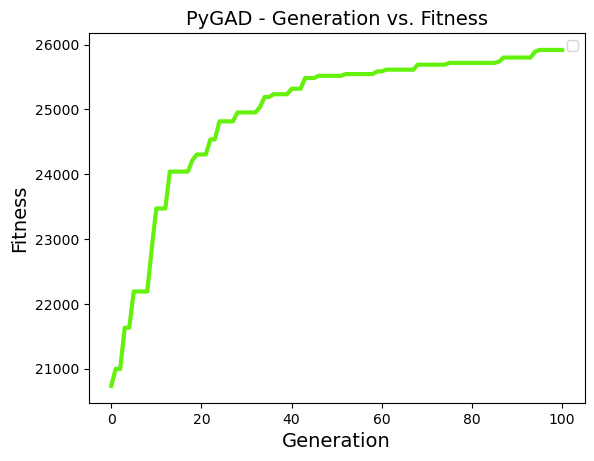

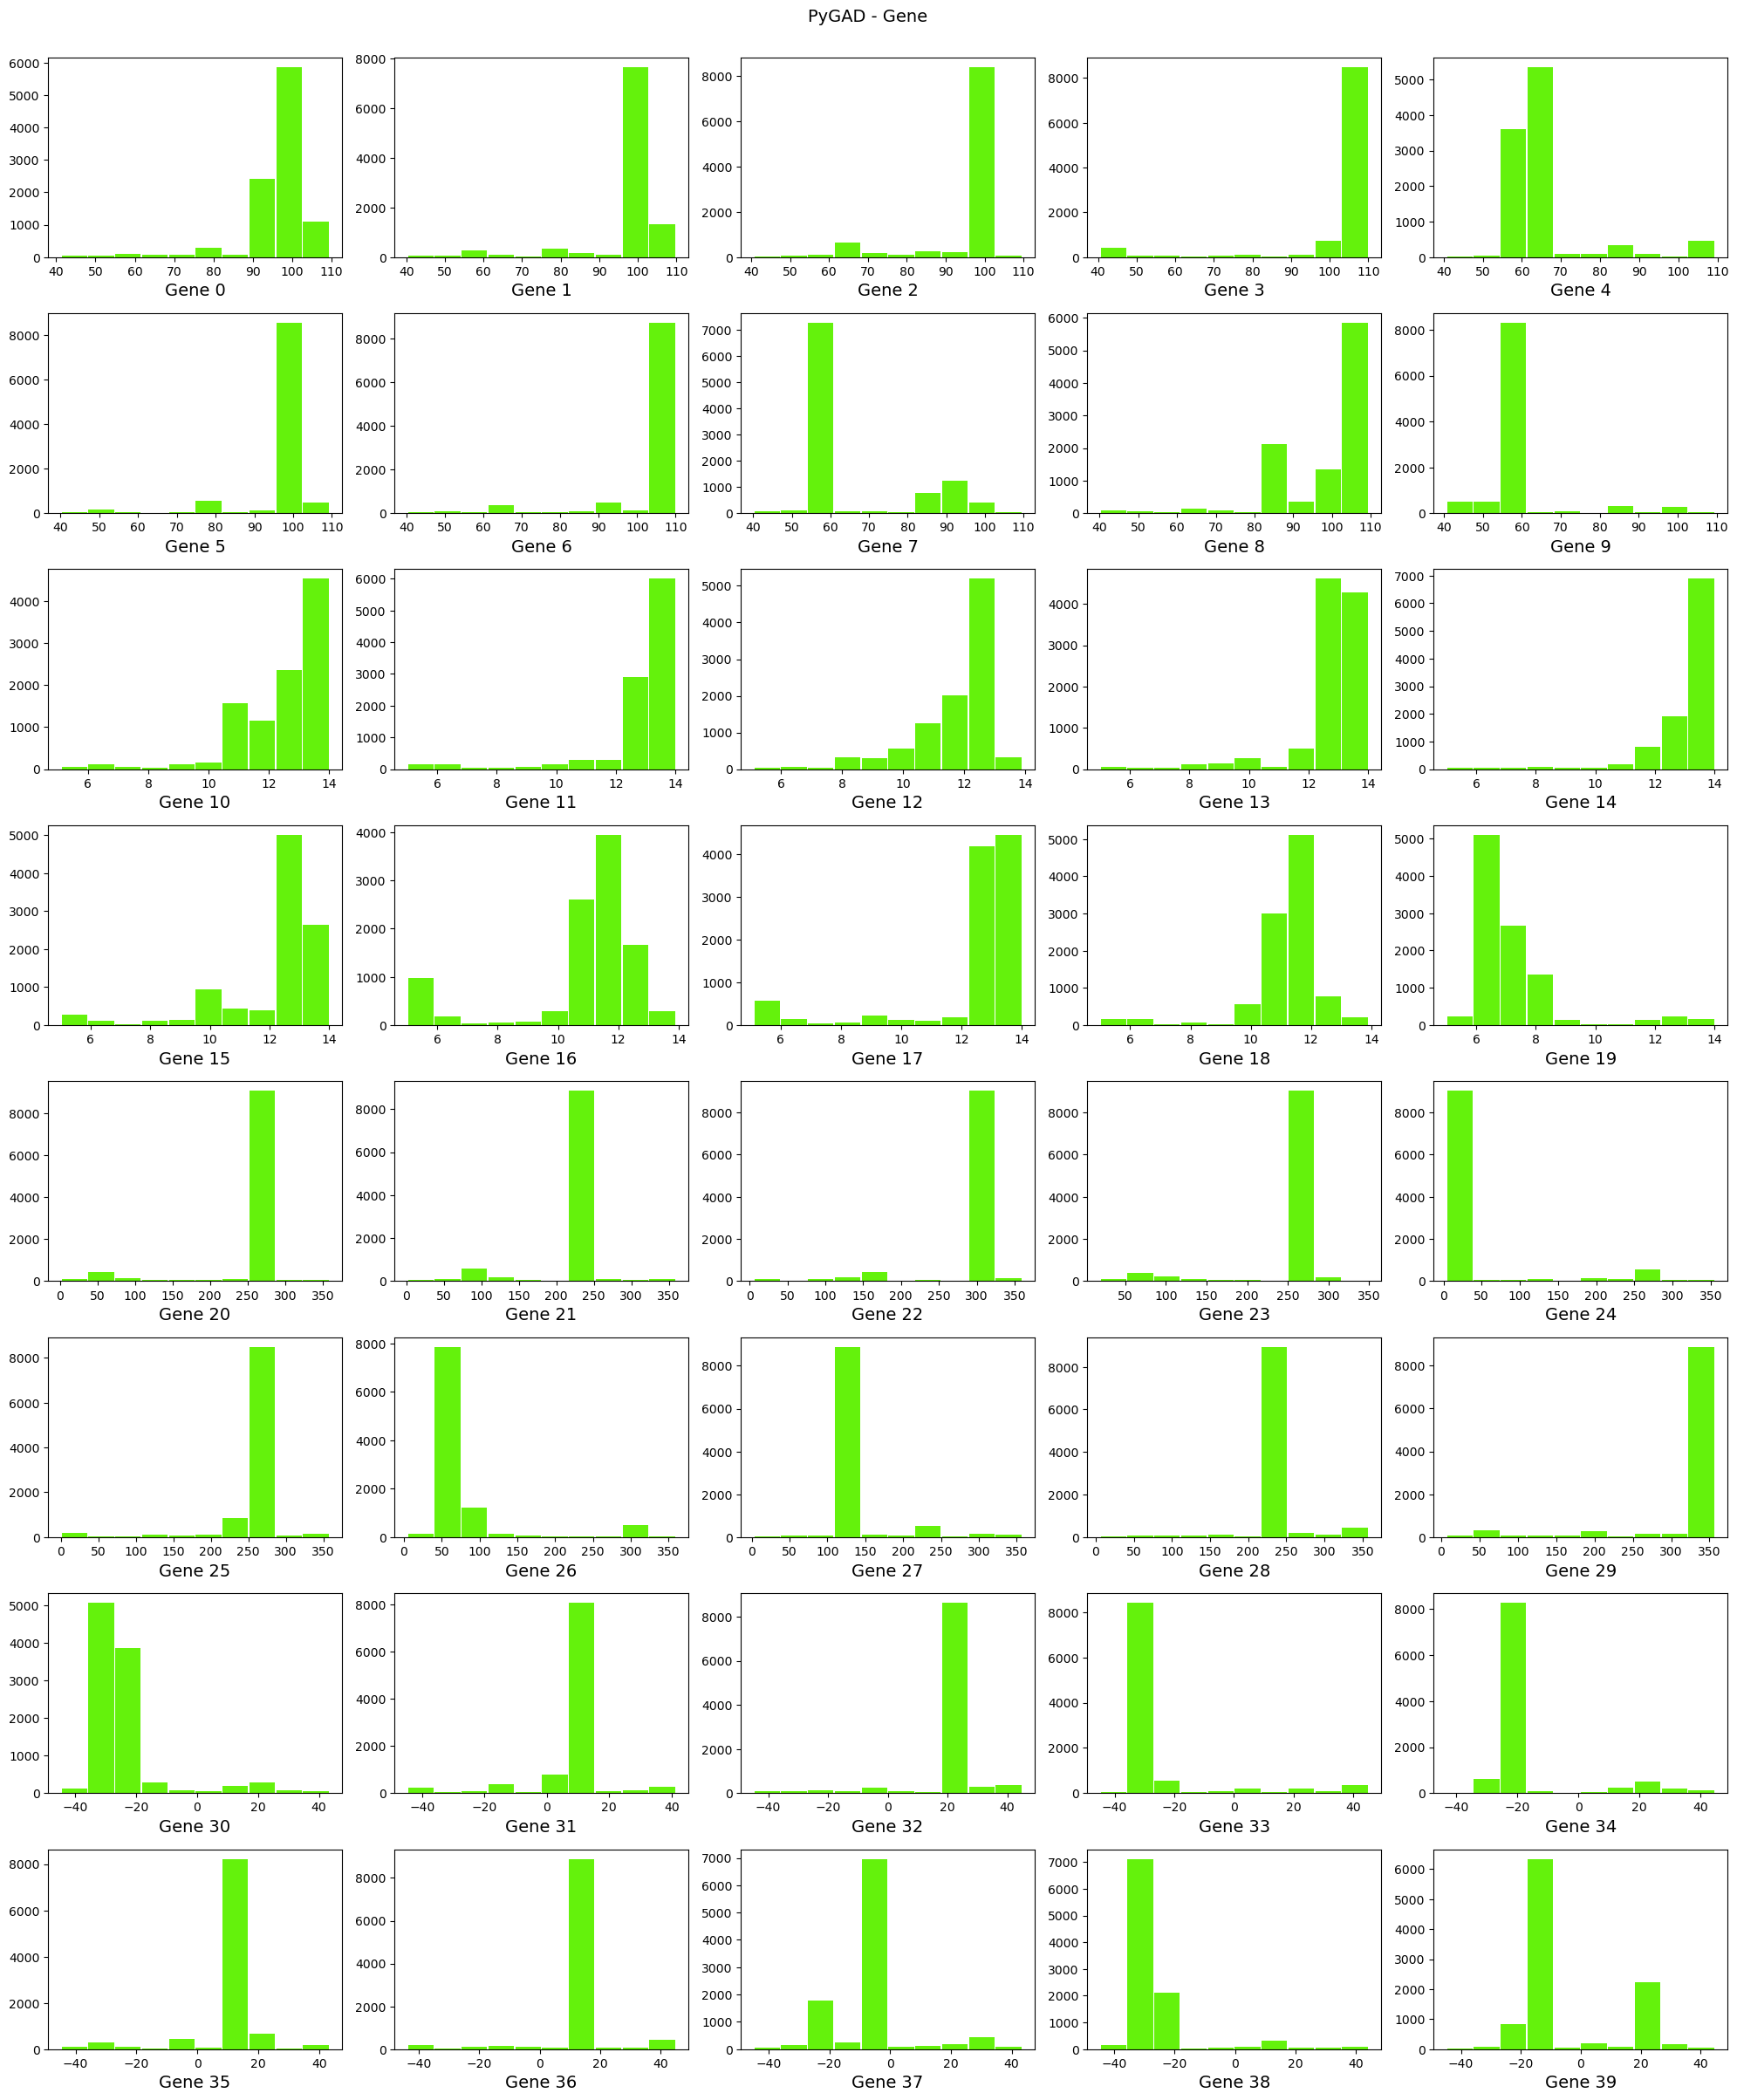

Best Solution: [104.4 103.4  97.6 109.9  62.1  97.  108.4  58.8 103.5  54.8  13.7  13.9
  12.2  13.4  13.2  13.7  12.6  13.1  11.2   6.6 278.2 232.7 315.2 278.5
  23.7 259.8  75.3 140.6 249.5 329.3 -26.6   7.2  23.2 -33.1 -23.8  14.5
  12.3  -7.8 -33.  -15.9]
Fitness value of the best solution = 25916.8


In [18]:
if __name__ == '__main__':
    main()

In [ ]:
# leaf angles:  -26.6   7.2  23.2 -33.1 -23.8  14.5 12.3  -7.8   -33.  -15.9

In [29]:
pygad.__version__

'3.3.1'

In [23]:
mesh = o3d.io.read_triangle_mesh("/work/mech-ai-scratch/nasla/PAR_model/GA_parallel/meshes/chromosome_41_11.obj")
old_center = mesh.get_center()
scale_factor = 0.01
mesh.scale(scale_factor, center=mesh.get_center())

# Translate the original mesh to the origin
mesh.translate(-mesh.get_center())
new_center = mesh.get_center()
print(old_center, new_center)

[ 0.4363634   6.67408405 98.02770327] [ 6.82786950e-15 -9.68211706e-14 -1.83326916e-12]
